In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import log, log2, floor
from pprint import pprint

dat = np.arange(0.0, 1.0, 0.00001)
num_bits = 2.0

## Linear: quantizing the given range linearly

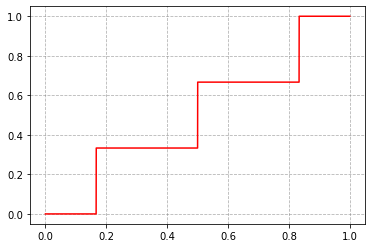

In [13]:
def linearQuant(data, bits, range=(0.0, 1.0)):
    base = (range[1] - range[0]) / (2.0**bits-1)
    return np.floor(data / base + 0.5) * base

linear_quant_dat = linearQuant(dat, num_bits)
plt.plot(dat, linear_quant_dat, 'r-')
plt.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()

## Log: quantizing on log base, the num_bits affects the minimum value

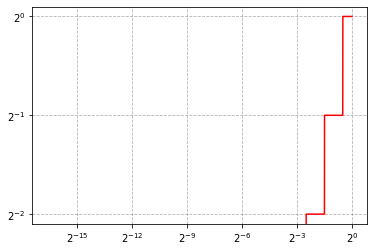

In [8]:
def logQuant(att, bits):
    exp = np.floor(np.log2(att) + 0.5)
    min_exp = -(2.0**bits-1)
    clamped_exp = np.copy(exp)
    clamped_exp[exp <= min_exp] = float("-inf")
    return np.power(2.0, clamped_exp)

log_quant_dat = logQuant(dat, num_bits)
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.plot(dat, log_quant_dat, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()

## Clamped log base: quantizing only the selecting range evenly on log base.

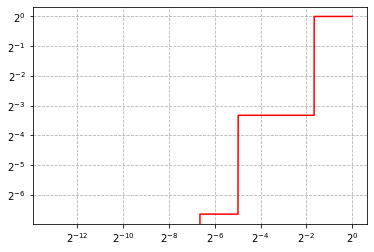

In [17]:
def clampedLogQuant(att, bits):
    min_exp = log2(0.001)
    step = min_exp / (2.0**bits-1)
    exp = np.log2(att)
    clamped_exp = np.floor(exp / step + 0.5) * step
    clamped_exp[exp < (min_exp - step)] = float("-Inf")
    return np.power(2.0, clamped_exp)

clamped_log_quant_dat = clampedLogQuant(dat, num_bits)
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.plot(dat, clamped_log_quant_dat, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()

## Binarization

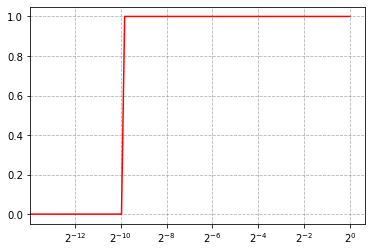

In [18]:
 def binQuant(att, bits):
     thres = 1e-3
     res_att = att.copy()
     res_att[att <= thres] = 0.0
     res_att[att > thres] = 1.0

     return res_att

bin_quant_dat = binQuant(dat, num_bits)
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
ax.plot(dat, bin_quant_dat, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()

## Ranking on the distribution:

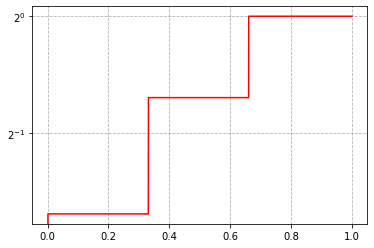

In [19]:
def rankingQuant(att, bits):
    min_val = 1e-3
    def ranking_search(row):
        num_ranks = int(2.0**bits - 1)
        thresholds = [1.0 / num_ranks * i for i in range(1, num_ranks)]
        return [np.argmax(row > threshold) for threshold in thresholds]

    # get fixed ranking position using numpy
    hist_x_start, hist_x_end = log(min_val, 10), log(1, 10)
    bin_edges = 10**np.linspace(hist_x_start, hist_x_end, 100+1)
    atts_np = np.apply_along_axis(
            lambda x: np.histogram(x, bin_edges, range=(min_val, 1.0))[0], -1,  att)
    atts_np = np.cumsum(np.apply_along_axis(lambda a: a / np.sum(a) if np.sum(a) > 0 else a, -1, atts_np), axis=-1)
    rank_idx = np.apply_along_axis(ranking_search, -1, atts_np)
    ranking_map = np.apply_along_axis(lambda x: bin_edges[x], -1, rank_idx)
    value_clamp_to = np.apply_along_axis(lambda x: bin_edges[x-1], -1, rank_idx)

    # fixed ranking position, from histogram observation
    zero_masks, compare_done_mask = np.ones(att.shape), np.ones(att.shape)
    zero_masks[att<min_val] = 0.0
    quant_att = np.zeros(att.shape)
    for thres, val in zip(np.split(ranking_map, ranking_map.shape[-1], axis=-1), np.split(value_clamp_to, value_clamp_to.shape[-1], axis=-1)):
        ranking_map_stacked = np.concatenate([thres]*quant_att.shape[-1], axis=-1)
        val_stacked = np.concatenate([val]*quant_att.shape[-1], axis=-1)
        quant_att += (att < ranking_map_stacked) * val_stacked * compare_done_mask
        compare_done_mask = att >= ranking_map_stacked
    quant_att += (att < 1.0) * 1.0 * compare_done_mask
    quant_att = quant_att * zero_masks
    
    return quant_att


ranking_quant_dat = rankingQuant(dat, num_bits)
fig, ax = plt.subplots()
# ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)
ax.plot(dat, ranking_quant_dat, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()

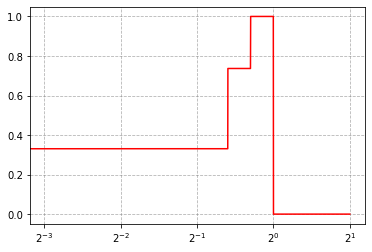

In [82]:
def rankingHeadQuant(att, bits):
    min_val = 1e-3
    def ranking_search(row):
        num_ranks = int(2.0**bits - 1)
        thresholds = [1.0 / num_ranks * i for i in range(1, num_ranks)]
        return [np.argmax(row > threshold) for threshold in thresholds]

    # get fixed ranking position using numpy
    hist_x_start, hist_x_end = log(min_val, 10), log(1, 10)
    bin_edges = 10**np.linspace(hist_x_start, hist_x_end, 100+1)
    atts_np = np.histogram(att.flatten(), bin_edges, range=(min_val, 1.0))[0]
    atts_np = np.cumsum(atts_np / np.sum(atts_np))
    rank_idx = ranking_search(atts_np)
    ranking_map = bin_edges[rank_idx]
    value_clamp_to = [(start+end)/2.0 for start, end in zip([min_val] + list(ranking_map[:-1]), ranking_map)]

    # fixed ranking position based on histogram
    zero_masks, compare_done_mask = np.ones(att.shape), np.ones(att.shape)
    zero_masks[att<min_val] = 0.0
    quant_att = np.zeros(att.shape)
    for thres, val in zip(ranking_map, value_clamp_to):
        quant_att += (att < thres) * val * compare_done_mask
        compare_done_mask = att >= thres
    quant_att += (att < 1.0) * 1.0 * compare_done_mask
    quant_att = quant_att * zero_masks

    return quant_att

dat = np.sort(np.random.normal(0.005, 6.0, size=1000))
dat = dat / np.amax(dat) + 1.0

ranking_head_quant_dat = rankingHeadQuant(dat, num_bits)
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
# ax.set_yscale('log', basey=2)
ax.plot(dat, ranking_head_quant_dat, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()